# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
import math
import os
from tqdm import tqdm

In [4]:
TRAIN_CSV = 'data/nyc-taxi/train.csv'
TEST_CSV = 'data/nyc-taxi/test.csv'

# Preliminary Explorations

In [ ]:
df_tmp = pd.read_csv(TRAIN_CSV, nrows=5)
df_tmp.head()

In [ ]:
df_tmp = pd.read_csv(TEST_CSV, nrows=5)
df_tmp.head()

In [ ]:
%%time

import subprocess

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])+1

n_rows = file_len(TRAIN_CSV)
print (f'Exact number of rows: {n_rows}')

The entire dataset has about 55,423,857 rows

# Load training and test data

In [8]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column)
cols_train = ['fare_amount', 'pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

# No 'fare_amount'
cols_test = ['pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [9]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. Or try 10 million
total_chunk = n_rows // chunksize + 1

print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')

Chunk size: 10,000,000
Total chunks required: 6


In [10]:
%%time
i=0
for df_chunk in tqdm(pd.read_csv(TRAIN_CSV, usecols=cols_train, dtype=types, chunksize=chunksize)):
    
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], format='%Y-%m-%d %H:%M') 
    
    df_list.append(df_chunk) 

6it [02:04, 19.42s/it]

CPU times: user 1min 56s, sys: 8.66 s, total: 2min 4s
Wall time: 2min 4s


In [11]:
train_df = pd.concat(df_list)

del df_list

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [13]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [14]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-raw')

CPU times: user 2.57 s, sys: 1.93 s, total: 4.5 s
Wall time: 11.7 s


In [15]:
test_df = pd.read_csv(TEST_CSV, usecols=cols_test, dtype=types)
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], format='%Y-%m-%d %H:%M') 

In [16]:
test_df.to_feather('tmp/taxi-test-raw')

# Load existing feather files

In [5]:
%%time
train_df = pd.read_feather('tmp/taxi-train-raw')
test_df = pd.read_feather('tmp/taxi-test-raw')

/home/szelee/anaconda3/envs/tf/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 897 ms, sys: 2.78 s, total: 3.68 s
Wall time: 10.1 s


# Remove missing values

In [6]:
train_df.isnull().sum()

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [7]:
test_df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df.dropna(how='any', axis='rows', inplace=True)

new_len = len(train_df)
print(f'New size: {old_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423856
New size: 55423856
376 rows removed


# Longitude and latitude

In [9]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [10]:
# Remove observations with useless values base on the test data boundary
longmin_limit = -75
longmax_limit = -72
latmin_limit = 40
latmax_limit = 42

In [11]:
is_outside_plong = ~train_df.pickup_longitude.between(longmin_limit,longmax_limit)
is_outside_plat = ~train_df.pickup_latitude.between(latmin_limit,latmax_limit)

is_outside_dlong = ~train_df.dropoff_longitude.between(longmin_limit,longmax_limit)
is_outside_dlat = ~train_df.dropoff_latitude.between(latmin_limit,latmax_limit)

is_outside_plong.sum(), is_outside_plat.sum(), is_outside_dlong.sum(), is_outside_dlat.sum()

(1099499, 1093981, 1094337, 1092582)

In [12]:
is_outside_range = is_outside_plong | is_outside_plat | is_outside_dlong | is_outside_dlat
is_outside_range.sum()

1166179

In [13]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[~is_outside_range] # keep those NOT outside range

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423480
New size: 54257301
1,166,179 rows removed


# Passenger Count

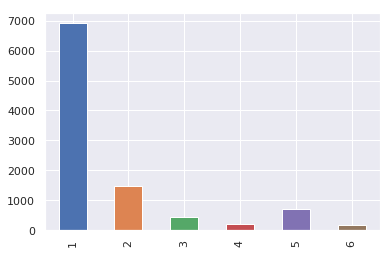

In [14]:
test_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [15]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

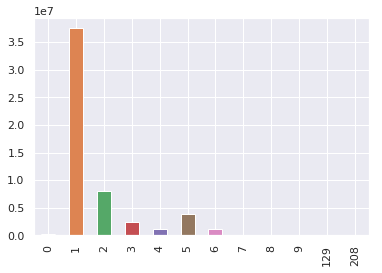

In [16]:
train_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [17]:
train_df.passenger_count.value_counts().sort_index()

0        190842
1      37521093
2       8013912
3       2383357
4       1155684
5       3842063
6       1150285
7            13
8             7
9            21
129           2
208          22
Name: passenger_count, dtype: int64

In [18]:
# number rows with passenger = 0 or more than 6
len(train_df[~(train_df.passenger_count.between(1,6))])

190907

In [19]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.passenger_count.between(1,6))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54257301
New size: 54066394
190,907 rows removed


# Fare Amount

In [20]:
# Check quantile
train_df[['fare_amount']].quantile([0.001, 0.999])

,fare_amount
0.001,2.500000
0.999,78.830002


In [21]:
train_df.fare_amount.median(), train_df.fare_amount.mean()

(8.5, 11.333876)

In [22]:
fare_max = 200
fare_min = 0

len(train_df[~(train_df.fare_amount.between(fare_min,fare_max))])

3491

In [23]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.fare_amount.between(fare_min,fare_max))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54066394
New size: 54062903
3,491 rows removed


In [24]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

# Date Time

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54062903 entries, 0 to 54062902
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [26]:
def split_datetime(data):
    # Extract date attributes and then drop the pickup_datetime column
    data['year'] = (data['pickup_datetime'].dt.year-2000).astype('uint8')  
    data['month'] = data['pickup_datetime'].dt.month.astype('uint8')  
    data['week'] = data['pickup_datetime'].dt.week.astype('uint8')  
    data['dayofweek'] = data['pickup_datetime'].dt.dayofweek.astype('uint8')  # dt.dayofweek = dt.weekday
    data['day'] = data['pickup_datetime'].dt.day.astype('uint8')  
    data['hour'] = data['pickup_datetime'].dt.hour.astype('uint8')  
    
    data.drop('pickup_datetime', axis=1, inplace=True)
    
    return data

In [27]:
%%time
train_df = split_datetime(train_df)

CPU times: user 31.3 s, sys: 7.2 s, total: 38.5 s
Wall time: 24.4 s


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54062903 entries, 0 to 54062902
Data columns (total 12 columns):
fare_amount          float32
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
year                 uint8
month                uint8
week                 uint8
dayofweek            uint8
day                  uint8
hour                 uint8
dtypes: float32(5), uint8(7)
memory usage: 1.4 GB


In [29]:
test_df = split_datetime(test_df)

# Add travel vector and distance

In [30]:
def add_travel_vector_features(data):
    data['longitude_distance'] = data.dropoff_longitude - data.pickup_longitude
    data['latitude_distance'] = data.dropoff_latitude - data.pickup_latitude
    
    data['manhattan_distance'] = (data['longitude_distance']).abs() + (data['latitude_distance']).abs()
    data['euclidean_distance'] = (data['longitude_distance'] ** 2 + data['latitude_distance'] ** 2) ** .5
    data['euclidean_distance'] = data['euclidean_distance'].astype('float32')
    
    return data

In [31]:
train_df = add_travel_vector_features(train_df)
test_df= add_travel_vector_features(test_df)

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54062903 entries, 0 to 54062902
Data columns (total 16 columns):
fare_amount           float32
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
year                  uint8
month                 uint8
week                  uint8
dayofweek             uint8
day                   uint8
hour                  uint8
longitude_distance    float32
latitude_distance     float32
manhattan_distance    float32
euclidean_distance    float32
dtypes: float32(9), uint8(7)
memory usage: 2.2 GB


In [33]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 15 columns):
pickup_longitude      9914 non-null float32
pickup_latitude       9914 non-null float32
dropoff_longitude     9914 non-null float32
dropoff_latitude      9914 non-null float32
passenger_count       9914 non-null uint8
year                  9914 non-null uint8
month                 9914 non-null uint8
week                  9914 non-null uint8
dayofweek             9914 non-null uint8
day                   9914 non-null uint8
hour                  9914 non-null uint8
longitude_distance    9914 non-null float32
latitude_distance     9914 non-null float32
manhattan_distance    9914 non-null float32
euclidean_distance    9914 non-null float32
dtypes: float32(8), uint8(7)
memory usage: 377.7 KB


# Add distance to city and airports

In [34]:
# def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
#     return (np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)).astype('float32')  

In [35]:
# haversine distance
def dist(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude = map(np.radians, [pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude])
    dlon = dropoff_longitude - pickup_longitude
    dlat = dropoff_latitude - pickup_latitude
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_latitude) * np.cos(dropoff_latitude) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6367 * c
    return distance.astype('float32')

In [36]:
def add_distance_to_city_airports(data):
    # Distances to city center, county and airports
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    
    # city center
    nyc = (40.7128,-74.0060) # New York City

    # county
    Nassau = (40.6546, -73.5594)
    Suffolk = (40.9849, -72.6151)
    Westchester = (41.1220, -73.7949)
    Rockland = (41.1489, -73.9830)
    Dutchess = (41.7784, -73.7478)
    Orange = (41.3912, -74.3118)
    Putnam = (41.4351, -73.7949) 
    
    # airports
    jfk = (40.6413,-73.7781) # John F. Kennedy International Airport
    ewr = (40.6895,-74.1745) # Newark Liberty International Airport
    lgr = (40.7769,-73.8740) # LaGuardia Airport
    
    data['pickup_distance_to_nyc'] = dist(nyc[0], nyc[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_nyc'] = dist(nyc[0], nyc[1], data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['pickup_distance_to_Nassau'] = dist(Nassau[0], Nassau[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_Nassau'] = dist(Nassau[0], Nassau[1], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_Suffolk'] = dist(Suffolk[0], Suffolk[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_Suffolk'] = dist(Suffolk[0], Suffolk[1], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_Westchester'] = dist(Westchester[0], Westchester[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_Westchester'] = dist(Westchester[0], Westchester[1], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_Rockland'] = dist(Rockland[0], Rockland[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_Rockland'] = dist(Rockland[0], Rockland[1], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_Dutchess'] = dist(Dutchess[0], Dutchess[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_Dutchess'] = dist(Dutchess[0], Dutchess[1], data['dropoff_longitude'], data['dropoff_latitude'])
    data['pickup_distance_to_Orange'] = dist(Orange[0], Orange[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_Orange'] = dist(Orange[0], Orange[1], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_Putnam'] = dist(Putnam[0], Putnam[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_Putnam'] = dist(Putnam[0], Putnam[1], data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['pickup_distance_to_jfk'] = dist(jfk[0], jfk[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = dist(jfk[0], jfk[1], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = dist(ewr[0], ewr[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = dist(ewr[0], ewr[1], data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = dist(lgr[0], lgr[1], data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = dist(lgr[0], lgr[1], data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data

In [37]:
%%time
train_df = add_distance_to_city_airports(train_df)

CPU times: user 2min 12s, sys: 1min 27s, total: 3min 39s
Wall time: 33.2 s


In [38]:
test_df = add_distance_to_city_airports(test_df)

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54062903 entries, 0 to 54062902
Data columns (total 38 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
year                               uint8
month                              uint8
week                               uint8
dayofweek                          uint8
day                                uint8
hour                               uint8
longitude_distance                 float32
latitude_distance                  float32
manhattan_distance                 float32
euclidean_distance                 float32
pickup_distance_to_nyc             float32
dropoff_distance_to_nyc            float32
pickup_distance_to_Nassau          float32
dropoff_distance_to_Nassau         float32
pickup_distance_to_Suffolk         floa

# Add boolean flag to show fare increased from September 2012

In [40]:
# merged to final_convert()
# def add_fare_increased_flag(data):
#     flag = (((data.year==(2012-2000)) & (data.month>=9)) | (data.year>(2012-2000)))
#     data['fare_increased'] = flag
    
#     return data

In [41]:
# train_df = add_fare_increased_flag(train_df)
# test_df = add_fare_increased_flag(test_df)

# Surcharges, fare increased etc

In [42]:
# Consider extra charges
def final_convert(data):

    # There is a 50-cent MTA State Surcharge for all trips that end in New York City or 
    # Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
    # The following two variables can be merged into one.
    # The following only considers trips that starts in city center and ends in nearby counties,
    # while the opposite direction could also be considered
    # counties
    data['county_dropoff_1'] = np.where((data['pickup_distance_to_nyc'] <= 5) &
                                     ((data['dropoff_distance_to_Nassau'] <= 21.3) |
                                      (data['dropoff_distance_to_Westchester'] <= 22.4)), True, False)
    
    data['county_dropoff_2'] = np.where((data['pickup_distance_to_nyc'] <= 5) &                  
                                     ((data['dropoff_distance_to_Suffolk'] <= 48.7) |           
                                      (data['dropoff_distance_to_Rockland'] <= 14.1) |
                                      (data['dropoff_distance_to_Dutchess'] <= 28.7) |
                                      (data['dropoff_distance_to_Orange'] <= 29) |
                                      (data['dropoff_distance_to_Putnam'] <= 15.7)), True, False)
    
    # Add boolean flag to show fare increased from September 2012
    data['fare_increased'] = np.where(((data.year==(2012-2000)) & (data.month>=9)) | 
                                       (data.year>(2012-2000)), True, False)
    
    # There is a daily 50-cent surcharge from 8pm to 6am.
    data['night_hour'] = np.where((data['hour'] >= 20) |
                                (data['hour'] <= 6) , True, False)
    
    # There is a $1 surcharge from 4pm to 8pm on weekdays, excluding holidays.
    data['peak_hour'] = np.where((data['hour'] >= 16) &
                                (data['hour'] <= 20) & 
                                (data['dayofweek'] >=0) &
                                (data['dayofweek'] <=4) , True, False)
    
    # This is a flat fare of $52 plus tolls, the 50-cent MTA State Surcharge, the 30-cent Improvement Surcharge, 
    # to/from JFK and any location in Manhattan:
    data['to_from_jfk'] = np.where(((data['pickup_distance_to_jfk'] <= 2) & (data['dropoff_distance_to_nyc'] <= 5)) | 
                                 ((data['pickup_distance_to_nyc'] <= 5) & (data['dropoff_distance_to_jfk'] <= 2)), True, False)

    # There is a $4.50 rush hour surcharge (4 PM to 8 PM weekdays, excluding legal holidays). o/from JFK and any location in Manhattan:
    data['jfk_rush_hour'] = np.where((data['to_from_jfk'] == 1) & 
                                   (data['hour'] >= 16) &
                                   (data['hour'] <= 20) , True, False)
    
    # There is a $17.50 Newark Surcharge to Newark Airport:
    data['ewr'] = np.where((data['pickup_distance_to_nyc'] <= 5) &
                         (data['dropoff_distance_to_ewr'] <= 1), True, False)
    
    return data

In [43]:
%%time
# Apply to both train and test data      
train_df = final_convert(train_df)
test_df = final_convert(test_df)

CPU times: user 27.4 s, sys: 6.16 s, total: 33.6 s
Wall time: 4.62 s


In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54062903 entries, 0 to 54062902
Data columns (total 46 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
year                               uint8
month                              uint8
week                               uint8
dayofweek                          uint8
day                                uint8
hour                               uint8
longitude_distance                 float32
latitude_distance                  float32
manhattan_distance                 float32
euclidean_distance                 float32
pickup_distance_to_nyc             float32
dropoff_distance_to_nyc            float32
pickup_distance_to_Nassau          float32
dropoff_distance_to_Nassau         float32
pickup_distance_to_Suffolk         floa

# Save feather

In [45]:
%%time
train_df.to_feather('tmp/taxi-train-clean-all')

CPU times: user 11 s, sys: 6.1 s, total: 17.1 s
Wall time: 6.77 s


In [46]:
%%time
test_df.to_feather('tmp/taxi-test-clean-all')

CPU times: user 26.7 ms, sys: 13.2 ms, total: 39.9 ms
Wall time: 24.2 ms


In [47]:
train_df.head(10)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,week,dayofweek,...,pickup_distance_to_lgr,dropoff_distance_to_lgr,county_dropoff_1,county_dropoff_2,fare_increased,night_hour,peak_hour,to_from_jfk,jfk_rush_hour,ewr
0,4.5,-73.844315,40.721317,-73.841614,40.712276,1,9,6,25,0,...,6.662795,7.681617,False,False,False,False,True,False,False,False
1,16.9,-74.016045,40.711304,-73.979271,40.782005,1,10,1,1,1,...,14.005035,8.876063,False,False,False,False,True,False,False,False
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2,11,8,33,3,...,9.314131,10.292645,False,False,False,True,False,False,False,False
3,7.7,-73.987129,40.733143,-73.991570,40.758091,1,12,4,16,5,...,10.692566,10.113103,False,False,False,True,False,False,False,False
4,5.3,-73.968094,40.768009,-73.956657,40.783764,1,10,3,10,1,...,7.979849,6.997129,False,False,False,False,False,False,False,False
5,12.1,-74.000961,40.731628,-73.972893,40.758232,1,11,1,1,3,...,11.812156,8.577767,False,False,False,False,False,False,False,False
6,7.5,-73.980003,40.751663,-73.973801,40.764843,1,12,11,47,1,...,9.352308,8.504800,False,False,True,True,True,False,False,False
7,16.5,-73.951302,40.774139,-73.990097,40.751049,1,12,1,1,2,...,6.511955,10.184617,False,False,False,False,True,False,False,False
8,9.0,-74.006462,40.726711,-73.993080,40.731628,1,12,12,49,0,...,12.467581,11.215397,False,False,True,False,False,False,False,False
9,8.9,-73.980659,40.733871,-73.991539,40.758137,2,9,9,36,2,...,10.172176,10.109831,False,False,False,True,False,False,False,False


In [48]:
# Check column names
print(train_df.columns)

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'week', 'dayofweek', 'day', 'hour', 'longitude_distance',
       'latitude_distance', 'manhattan_distance', 'euclidean_distance',
       'pickup_distance_to_nyc', 'dropoff_distance_to_nyc',
       'pickup_distance_to_Nassau', 'dropoff_distance_to_Nassau',
       'pickup_distance_to_Suffolk', 'dropoff_distance_to_Suffolk',
       'pickup_distance_to_Westchester', 'dropoff_distance_to_Westchester',
       'pickup_distance_to_Rockland', 'dropoff_distance_to_Rockland',
       'pickup_distance_to_Dutchess', 'dropoff_distance_to_Dutchess',
       'pickup_distance_to_Orange', 'dropoff_distance_to_Orange',
       'pickup_distance_to_Putnam', 'dropoff_distance_to_Putnam',
       'pickup_distance_to_jfk', 'dropoff_distance_to_jfk',
       'pickup_distance_to_ewr', 'dropoff_distance_to_ewr',
       'pickup_distance_to_lgr', 'dropoff_distance_to_lg

In [54]:
%%time
train_df = pd.read_feather('tmp/taxi-train-clean-all')
test_df = pd.read_feather('tmp/taxi-test-clean-all')

/home/szelee/anaconda3/envs/tf/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 4.17 s, sys: 5.57 s, total: 9.74 s
Wall time: 9.74 s


In [55]:
# Check corr of 'fare_amount' to all the other variables
print(train_df.corrwith(train_df['fare_amount']))

fare_amount                        1.000000
pickup_longitude                   0.377192
pickup_latitude                   -0.189887
dropoff_longitude                  0.280312
dropoff_latitude                  -0.156175
passenger_count                    0.013259
year                               0.116132
month                              0.024261
week                               0.024193
dayofweek                          0.003019
day                                0.001443
hour                              -0.017268
longitude_distance                -0.095653
latitude_distance                  0.015911
manhattan_distance                 0.813714
euclidean_distance                 0.831464
pickup_distance_to_nyc             0.284788
dropoff_distance_to_nyc            0.314433
pickup_distance_to_Nassau         -0.415618
dropoff_distance_to_Nassau        -0.288167
pickup_distance_to_Suffolk        -0.322381
dropoff_distance_to_Suffolk       -0.212125
pickup_distance_to_Westchester  

In [56]:
# We can choose to remove the variables that has the corr less than 0.1
train_df = train_df.drop(['passenger_count','hour','day','month','dayofweek'], axis = 1)
test_df = test_df.drop(['passenger_count','hour','day','month','dayofweek'], axis = 1)

In [57]:
# Check corr of 'fare_amount' to all the other variables
print(train_df.corrwith(train_df['fare_amount']))

fare_amount                        1.000000
pickup_longitude                   0.377192
pickup_latitude                   -0.189887
dropoff_longitude                  0.280312
dropoff_latitude                  -0.156175
year                               0.116132
week                               0.024193
longitude_distance                -0.095653
latitude_distance                  0.015911
manhattan_distance                 0.813714
euclidean_distance                 0.831464
pickup_distance_to_nyc             0.284788
dropoff_distance_to_nyc            0.314433
pickup_distance_to_Nassau         -0.415618
dropoff_distance_to_Nassau        -0.288167
pickup_distance_to_Suffolk        -0.322381
dropoff_distance_to_Suffolk       -0.212125
pickup_distance_to_Westchester     0.127682
dropoff_distance_to_Westchester    0.120072
pickup_distance_to_Rockland        0.252236
dropoff_distance_to_Rockland       0.215233
pickup_distance_to_Dutchess        0.156341
dropoff_distance_to_Dutchess    

In [58]:
# We can choose to remove the variables that has the corr less than 0.1
train_df = train_df.drop(['week','latitude_distance','dropoff_distance_to_Dutchess', 'night_hour', 'peak_hour','county_dropoff_2','pickup_distance_to_lgr'], axis = 1)
test_df = test_df.drop(['week','latitude_distance', 'dropoff_distance_to_Dutchess', 'night_hour', 'peak_hour', 'county_dropoff_2','pickup_distance_to_lgr'], axis = 1)

In [59]:
# Check corr of 'fare_amount' to all the other variables
print(train_df.corrwith(train_df['fare_amount']))

fare_amount                        1.000000
pickup_longitude                   0.377192
pickup_latitude                   -0.189887
dropoff_longitude                  0.280312
dropoff_latitude                  -0.156175
year                               0.116132
longitude_distance                -0.095653
manhattan_distance                 0.813714
euclidean_distance                 0.831464
pickup_distance_to_nyc             0.284788
dropoff_distance_to_nyc            0.314433
pickup_distance_to_Nassau         -0.415618
dropoff_distance_to_Nassau        -0.288167
pickup_distance_to_Suffolk        -0.322381
dropoff_distance_to_Suffolk       -0.212125
pickup_distance_to_Westchester     0.127682
dropoff_distance_to_Westchester    0.120072
pickup_distance_to_Rockland        0.252236
dropoff_distance_to_Rockland       0.215233
pickup_distance_to_Dutchess        0.156341
pickup_distance_to_Orange          0.347947
dropoff_distance_to_Orange         0.288095
pickup_distance_to_Putnam       

In [60]:
%%time
train_df.to_feather('tmp/taxi-train-clean')

CPU times: user 9.1 s, sys: 6.31 s, total: 15.4 s
Wall time: 1min 29s


In [61]:
%%time
test_df.to_feather('tmp/taxi-test-clean')

CPU times: user 30.5 ms, sys: 7.57 ms, total: 38.1 ms
Wall time: 23.7 ms


In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54062903 entries, 0 to 54062902
Data columns (total 34 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
year                               uint8
longitude_distance                 float32
manhattan_distance                 float32
euclidean_distance                 float32
pickup_distance_to_nyc             float32
dropoff_distance_to_nyc            float32
pickup_distance_to_Nassau          float32
dropoff_distance_to_Nassau         float32
pickup_distance_to_Suffolk         float32
dropoff_distance_to_Suffolk        float32
pickup_distance_to_Westchester     float32
dropoff_distance_to_Westchester    float32
pickup_distance_to_Rockland        float32
dropoff_distance_to_Rockland       float32
pickup_distance_to_Dutchess        float32
pickup_distance_to_Orange  